<img src="https://s3.amazonaws.com/weclouddata/images/logos/wcd_logo_new_2.png" width="10%">
<h1><center>Computer Vision Project Template (Segmentation)</center></h1>

---

For this notebook, we will be using the Project Template.

The goal of the template is to make the Capstone Project implementation easy for the user.

# ML Project

There are 5 core components of a ML Project:
- Problem Statement
- Dataset
- DL Model
- Model Training
- Model Evaluation

The Template provides wrappers (Data and Model classes) and an API (ModelEngine) that works hand-in-hand with a Configuration. Together, they form a complete Training API.


Download and install the template

In [1]:
# !git clone https://github.com/jjaskirat/wcd_project_template.git
# %cd wcd_project_template
# ! python setup.py install
# %cd ..

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
import time
import os
import copy
from typing import Optional

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import random
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import torchvision
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Problem Statement

---

Visual scene understanding of drone images has sparked great interest in the computer vision community, as it presents new challenges and potential for high-resolution drone image processing and complicated drone vision tasks like depth estimation[24, 23, 25], 3D reconstruction[12, 10], obstacle avoidance[42] and adaptive path planning[38, 32]. We propose Varied Drone Dataset(VDD), a varied and large dataset of 400 high-resolution images to facilitate future research in semantic segmentation of drone images, and we believe that VDD will pave the way for new approaches in the field of aerial image processing.

## Dataset

---

The Semantic Drone Dataset focuses on semantic understanding of urban scenes for increasing the safety of autonomous drone flight and landing procedures. The imagery depicts  more than 20 houses from nadir (bird's eye) view acquired at an altitude of 5 to 30 meters above ground. A high resolution camera was used to acquire images at a size of 6000x4000px (24Mpx). The training set contains 400 publicly available images and the test set is made up of 200 private images.
Person Detection
For the task of person detection the dataset contains bounding box annotations of the training and test set.
Semantic Segmentation
We prepared pixel-accurate annotation for the same training and test set. The complexity of the dataset is limited to 20 classes as listed in the following table.   Table 1: Semanic classes of the Drone Dataset

- tree
- gras
- other vegetation
- dirt
- gravel
- rocks
- water
- paved area
- pool
- person
- dog
- car
- bicycle
- roof
- wall
- fence
- fence-pole
- window
- door
- obstacle

Additional Data Available

- High resolution images at 1Hz
- Fish-eye stereo images at 5Hz with synchronized IMU measurements
- Thermal images at 1Hz
- Ground control points
- 3D ground truth of 3 houses acquired by a total station

In [4]:
import kagglehub

# Download latest version
ROOT_DIR = kagglehub.dataset_download("bulentsiyah/semantic-drone-dataset")

print("Path to dataset files:", ROOT_DIR)
print("Contents of Data Dir: ", os.listdir(ROOT_DIR))

Path to dataset files: /root/.cache/kagglehub/datasets/bulentsiyah/semantic-drone-dataset/versions/6
Contents of Data Dir:  ['class_dict_seg.csv', 'dataset', 'RGB_color_image_masks']


In [5]:
# Set Global Variable of num classes
NUM_CLASSES = 23 

In [6]:
# Show the img_dir

img_dir = f'dataset/semantic_drone_dataset/original_images'
print("Contents of Img Dir: ", os.listdir(f'{ROOT_DIR}/{img_dir}')[:5])

mask_dir = f'dataset/semantic_drone_dataset/label_images_semantic'
print("Contents of Mask Dir: ", os.listdir(f'{ROOT_DIR}/{mask_dir}')[:5])

Contents of Img Dir:  ['355.jpg', '002.jpg', '251.jpg', '458.jpg', '565.jpg']
Contents of Mask Dir:  ['569.png', '338.png', '535.png', '598.png', '181.png']


Creation of DataFrame for dataset

The DataFrame will contain relative paths of the images and the labels of the dataset

In [7]:
def create_df():
    img_path = []
    mask_path = []
    # Loop through all images
    for dirname, _, filenames in os.walk(os.path.join(ROOT_DIR, img_dir)):
        for filename in filenames:
            # Append image path and mask path to their lists
            img_path.append(os.path.join(img_dir, filename))
            mask_path.append(os.path.join(mask_dir, f'{filename[:-3]}png'))
    # Create df
    df = pd.DataFrame({
            'image': img_path,
            'mask': mask_path,
    })
    return df

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [8]:
df

image  \
0    dataset/semantic_drone_dataset/original_images...   
1    dataset/semantic_drone_dataset/original_images...   
2    dataset/semantic_drone_dataset/original_images...   
3    dataset/semantic_drone_dataset/original_images...   
4    dataset/semantic_drone_dataset/original_images...   
..                                                 ...   
395  dataset/semantic_drone_dataset/original_images...   
396  dataset/semantic_drone_dataset/original_images...   
397  dataset/semantic_drone_dataset/original_images...   
398  dataset/semantic_drone_dataset/original_images...   
399  dataset/semantic_drone_dataset/original_images...   

                                                  mask  
0    dataset/semantic_drone_dataset/label_images_se...  
1    dataset/semantic_drone_dataset/label_images_se...  
2    dataset/semantic_drone_dataset/label_images_se...  
3    dataset/semantic_drone_dataset/label_images_se...  
4    dataset/semantic_drone_dataset/label_images_se...  
..                                                 ...  
395  dataset/semantic_drone_dataset/label_images_se...  
396  dataset/semantic_drone_dataset/label_images_se...  
397  dataset/semantic_drone_dataset/label_images_se...  
398  dataset/semantic_drone_dataset/label_images_se...  
399  dataset/semantic_drone_dataset/label_images_se...  

[400 rows x 2 columns]

# Data Exploration and Visualization

In [9]:
def plot_drone_data(df, num_images):
    for i in range(num_images):
        # Get random index
        random_idx = np.random.randint(0, len(df))
        # Get image
        image = cv2.imread(f"{ROOT_DIR}/{df.iloc[random_idx]['image']}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Get mask
        mask = df.iloc[random_idx]['mask']
        mask = cv2.imread(f"{ROOT_DIR}/{df.iloc[random_idx]['mask']}")
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        
        # Plot both the images in 2 columns
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,36))
        ax1.imshow(image)
        ax2.imshow(mask)
        ax1.set_title('Image')
        ax2.set_title('Mask')
        plt.show()

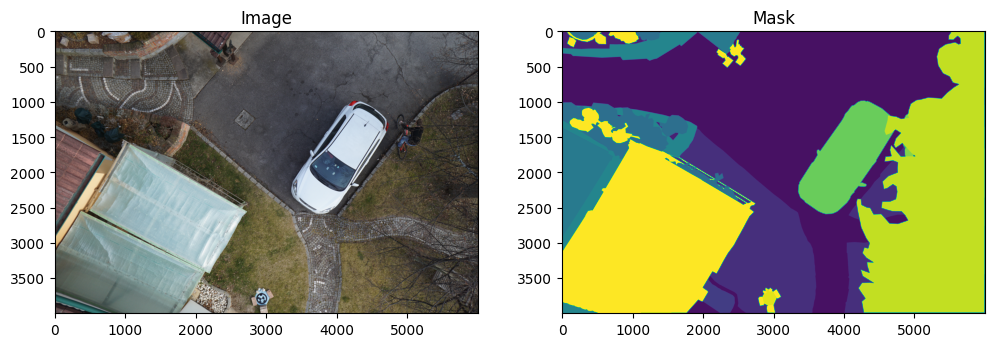

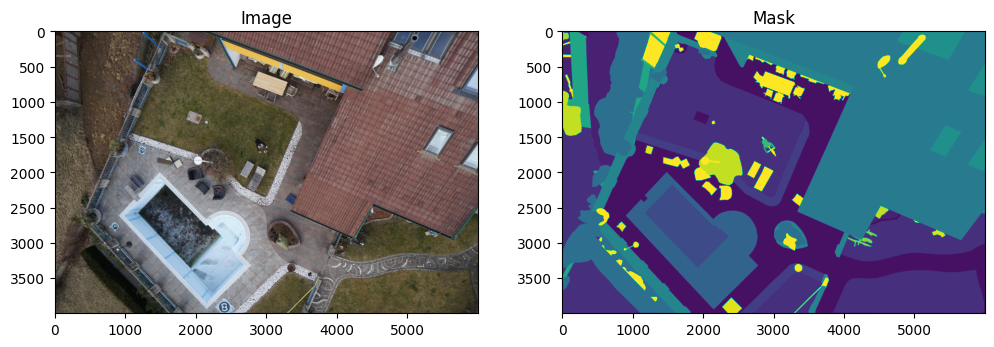

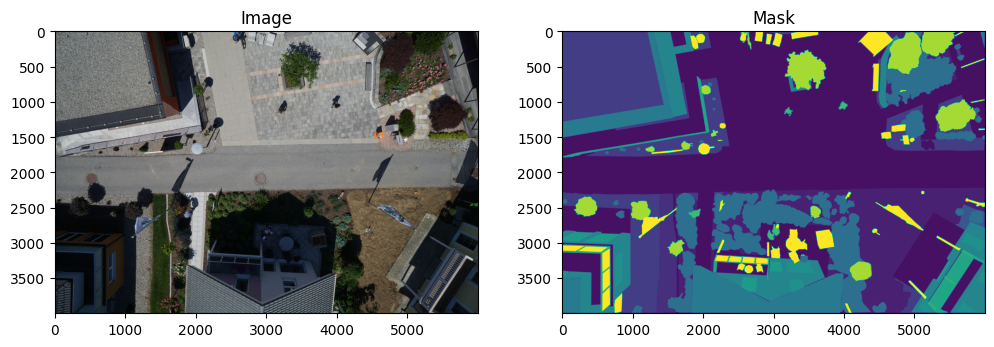

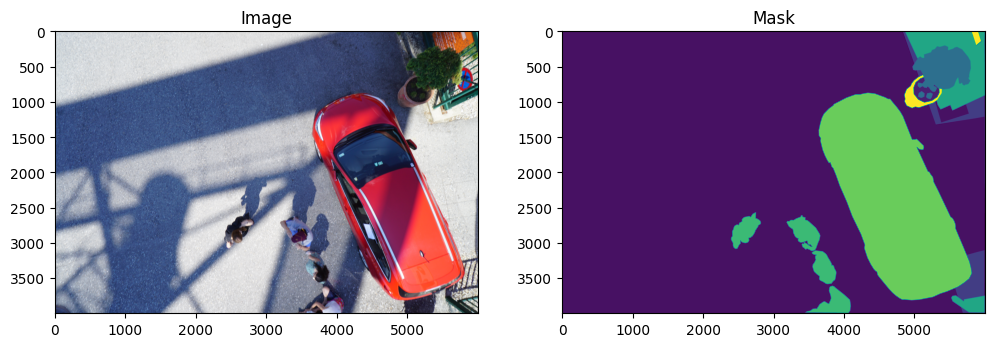

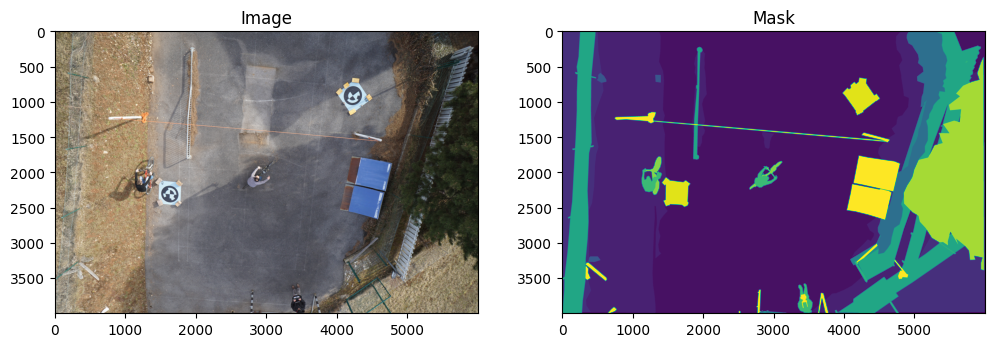

In [10]:
plot_drone_data(df, 5)

## Dataset Creation

The template provides a wrapper on top of a torch Dataset.

The user is responsible to create their own dataset and load it in PyTorch.

The `Data` class inherits from the `torch.utils.data.Dataset` class. It implements the `__len__` and the `__getitem__` functions. The user must implement the `get_input`, `get_label` and `apply_transform` functions, which define how the input and the labels can be obtained from a `pd.core.frame.DataFrame`

In [11]:
# Import Data from the template
from wcd_project_template.data import Data

In [12]:
class DataSegmentation(Data):
    def __init__(
            self,
            df,
            config_data: dict,
            transform: Optional[A.Compose] = None
        ):
        super().__init__(df, config_data, transform)

    def get_input(self, row):
        """defines how you get the input image from the df

        Returns:
            np.ndarray: the image
        """
        input_path = os.path.join(self.root_dir, row['image'])
        input = cv2.imread(input_path)
        input = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)
        return input

    def get_label(self, row):
        """defines how you get the label
        (classification or mask or objects) from the df

        Returns:
            Union[np.ndarray, int]: the label
        """
        label_path = os.path.join(self.root_dir, row['mask'])
        label = cv2.imread(label_path)
        label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
        return label

    def apply_transform(self, input, label):
        """applies the transformation on both the image and the label respectively.
        For classification, we do not need to apply any transformation on the label.

        Returns:
            Tuple[np.ndarray, int, torch.Tensor]: the transformed images and labels
        """
        transformed = self.transform(image=input, mask=label)
        input = transformed['image']
        label = transformed['mask']
        label = torch.as_tensor(label, dtype=torch.long)
        # label = torch.nn.functional.one_hot(label, 23)
        return input, label

Define the Transforms

Please note, we also create an inverse_transformation for valid_transformations

In [13]:
# We will use the Albumentations Library for transforms
# https://albumentations.ai/docs/

# Selected Transforms:
# - Resize
# - Horizontal Flip
# - GridDistortion
# - RandomBrightnessContrast
# - GaussNoise
# - Normalize according to Imagenet Mean and Std
# - Convert to Tensor

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

transforms_train = A.Compose(
    [
        A.Resize(768, 768),
        A.HorizontalFlip(p=0.5),
        A.GridDistortion(p=0.2),
        A.RandomBrightnessContrast((0,0.5),(0,0.5)),
        A.GaussNoise(p=0.8),
        A.Normalize(
            mean=mean.tolist(),
            std=std.tolist(),
            max_pixel_value=255,
        ),
        ToTensorV2(),
    ]
)

# Note: In validation transforms, we do not add the Horizontal Flip transform
transforms_valid = A.Compose(
    [
        A.Resize(768, 768),
        A.Normalize(
            mean=mean.tolist(),
            std=std.tolist(),
            max_pixel_value=255,
        ),
        ToTensorV2(),
    ]
)

# Validation Inverse Transforms
# This essentially does an unnormalize on the image.
# We can use this transformation to get the original
# image back after applying the transforms to it
transforms_valid_inverse = A.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

In [14]:
# Training Data config
config_dataset_train = {
    'root_dir': ROOT_DIR,
    'dataloader': {
        'batch_size': 8,
        'shuffle': True,
        'num_workers': 4
    },
}

# Validation data config
config_dataset_valid = {
    'root_dir': ROOT_DIR,
    'dataloader': {
        'batch_size': 8,
        'shuffle': False,
        'num_workers': 4
    },
}

Convert the dataset into train, valid and test set

10% test set | 9% valid set | 91% train set

In [15]:
# We use train_test_split from sklearn to connvert the df into train, valid and test sets

df_trainval, df_test = train_test_split(df, test_size=0.1, random_state=19)
df_train, df_valid = train_test_split(df_trainval, test_size=0.1, random_state=19)

print('Train Size   : ', len(df_train))
print('Val Size     : ', len(df_valid))
print('Test Size    : ', len(df_test))

Train Size   :  324
Val Size     :  36
Test Size    :  40


In [16]:
# Now we need to create the 

# Training Data
data_train = DataSegmentation(
    df_train,
    config_dataset_train,
    transform=transforms_train
)
# Validation Data
data_valid = DataSegmentation(
    df_valid,
    config_dataset_valid,
    transform=transforms_valid
)
# Testing Data
data_test = DataSegmentation(
    df_test,
    config_dataset_valid,
    transform=transforms_valid
)

Checking what the data looks like

In [17]:
data_train[0]

(tensor([[[ 0.1597,  0.0741, -0.0972,  ..., -0.3369,  0.0569, -0.6109],
          [ 0.1083,  0.0741, -0.1314,  ...,  0.3652,  0.0056,  0.2453],
          [ 0.0912,  0.2282,  0.0056,  ...,  1.0502,  0.9988,  0.9988],
          ...,
          [ 0.9646,  1.3584,  2.0605,  ..., -0.5253, -0.7822, -0.7308],
          [ 1.8550,  2.0605,  2.1804,  ..., -0.7479, -0.3883, -0.3883],
          [ 1.4440,  2.0434,  2.0948,  ..., -0.6281, -0.5596, -0.3883]],
 
         [[ 0.5903,  0.4678,  0.4153,  ..., -0.0224,  0.3803, -0.0749],
          [ 0.4503,  0.3452,  0.3978,  ...,  0.5903,  0.3102,  0.5378],
          [ 0.6604,  0.4853,  0.4503,  ...,  1.2381,  1.2381,  1.2031],
          ...,
          [ 1.6583,  2.4111,  2.3410,  ..., -0.8627, -0.8978, -0.7052],
          [ 2.3585,  2.4286,  2.4111,  ..., -0.2500, -0.3375, -0.2150],
          [ 2.1660,  2.4111,  2.3761,  ..., -0.4776, -0.3901, -0.5476]],
 
         [[ 1.0365,  0.8099,  0.9668,  ..., -0.5147, -0.4275, -0.6890],
          [ 0.8797,  1.0365,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0895599].


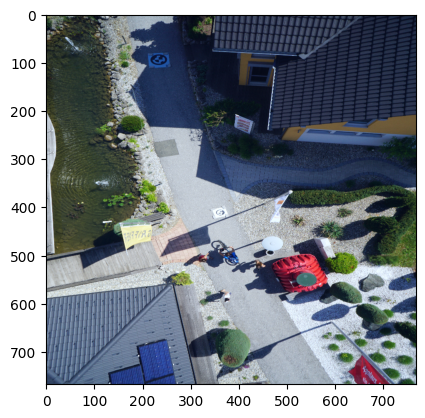

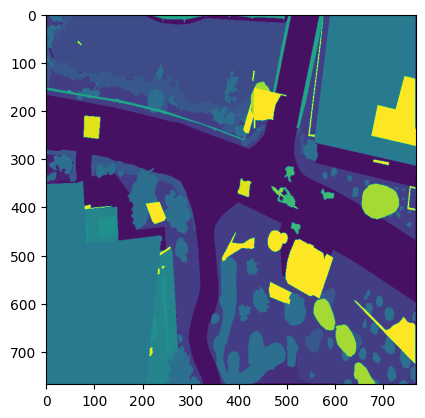

In [18]:
img, label = data_train[0]
img = transforms_valid_inverse(image=img.numpy()*255)['image']
plt.imshow(img.transpose((2,1,0)))
plt.show()
plt.imshow(label)
plt.show()

## DL Model

---

he template provides a wrapper on top of a torch model. The template provides the usage of 3 different libraries:
- `timm`, `segmentation-models-pytorch` and `detectron2`

For Segmentation Purposes:
- segmentation-models-pytorch
    - [Github and Documentation](https://github.com/qubvel-org/segmentation_models.pytorch)
    - comprehensive list of Segmentation models,
    - Ex: DeepLabV3, Unet, FPN, etc
    - It uses the `timm` models as encoder to the segmenation model.

In [19]:
# Import Model from the template
from wcd_project_template.model import Model

The `Model` configuration consists of the `model_hyperparameters` to specify the parameters of the model. Then it consists of a `weights_path` where you can load pretrained model_weights from. Finally a `freeze_layer` which specifies the layers you want to freeze (perform no backpropagation on)

In [20]:
# To create a wcd_project_template.model.Model,
# we need a configuration file and a model
# We define the configuration as seen below.
# model_hyperparameters is 
config_model = {
    'model_hyperparameters':{
        'encoder_name': 'resnet101',
        'encoder_depth': 5,
        'encoder_weights': 'imagenet',
        'classes': 23,
        'activation': None,
    },
    'weights_path': None,
    'freeze_layers': [],
}

# refer to https://smp.readthedocs.io/en/latest/models.html
# For all other segmentation models available

model_ = smp.DeepLabV3Plus(
    **config_model['model_hyperparameters']
)
model = Model(model_, config_model)

done loading model


In [21]:
model

Model(
  (model): DeepLabV3Plus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU

### Things to note about the smp models:

- The model head always predicts an output of dimensions (batch_size, num_classes, img_h, img_w)

## Model Training

---

The template provides you with a `ModelEngine` class. This class is responsible for supervised model training and evaluation. The code for training or evaluating the model is generally the same for every model. The components that change are the `Loss`, `Metric` and `Optimizer`.
- Loss
    - The loss function can be imported from any library
    - It can also be a custom loss function as seen [here](https://discuss.pytorch.org/t/custom-loss-functions/29387/2)
- Metric
    - Any metric can be used from the library `torchmetrics`.
    - Options for a custom metric are also provided [here](https://lightning.ai/docs/torchmetrics/stable/pages/implement.html)
- Optimizer
    - The optimizer must be from the `torch.optim` module.
    - Any optimizer can be selected
    - Options for a custom optimizer are also provided on the docs

### For Segmentation

- Loss
    - We can use the Loss provided in the smp library

- Metric
    - Since we are solving a multiclass problem, the metric input should be of size (batch_size, 1, img_h, img_w)
    - We need to apply Argmax (which is selecting the maximum valued class from the softmax output) to the output of the model here
    - We use 2 different metrics, IOU and Dice Score

- Optimizer
    - We use the standard Adam Optimizer

In [22]:
# Import ModelEngine from the template
from wcd_project_template.model_engine import ModelEngine

In [23]:
engine = ModelEngine('cuda')

The Model Engine config consists of the training parameters like `num_epochs`, then it contains sections where you can modify the `criterion`, `metric` and `optimizer`

The `name` parameter is a string corresponding to the import string of the Class. Except for the Optimizer, where it is the optimizer name

The `config` is the kwargs for the Class imported from the `name` parameter



In [24]:
# Loss  ------------------------
# Defined under config

In [25]:
from torchmetrics import MetricCollection
from torchmetrics.segmentation import MeanIoU, GeneralizedDiceScore

class MeanIoUWithArgMax(MeanIoU):
    # https://lightning.ai/docs/torchmetrics/stable/segmentation/mean_iou.html
    def __call__(self, preds, target):
        preds = torch.argmax(preds, dim=1)
        return super().__call__(preds, target)
    
class GeneralizedDiceScoreWithArgMax(GeneralizedDiceScore):
    # https://lightning.ai/docs/torchmetrics/stable/segmentation/generalized_dice.html
    def __call__(self, preds, target):
        preds = torch.argmax(preds, dim=1)
        return super().__call__(preds, target)

In [26]:
# Optimizer ---------------------
# Defined under config

In [27]:
config_training = {
    'num_epochs': 75,
    'optimizer': {
        # Corresponds to the Optimizer present in torch.optim
        # https://pytorch.org/docs/stable/optim.html
        'name': 'Adam',
        # Configuration of the optimizer
        'config': {
            'lr': 0.001,
            'weight_decay': 1e-5,
        },
    },
    'criterion': {
        # Dice Loss from smp
        # https://smp.readthedocs.io/en/latest/losses.html#diceloss
        'name': 'segmentation_models_pytorch.losses.DiceLoss',
        # Criterion configuration
        'config': {
            'mode': 'multiclass',
            'classes': NUM_CLASSES,
            'from_logits': True,
        },
    },
    'metric':{
        # Collection of Metrics
        # https://lightning.ai/docs/torchmetrics/stable/pages/overview.html#metriccollection
        'name': MetricCollection,
        'config':{
            'metrics': [
                MeanIoUWithArgMax(
                    num_classes=NUM_CLASSES,
                    input_format='index',
                    per_class=False,
                    include_background=True,
                ),
                GeneralizedDiceScoreWithArgMax(
                    num_classes=NUM_CLASSES,
                    input_format='index',
                    per_class=False,
                    include_background=True,
                )
            ]
        }
    }
}

config_evaluation = {
    'criterion': {
        # Dice Loss from smp
        # https://smp.readthedocs.io/en/latest/losses.html#diceloss
        'name': 'segmentation_models_pytorch.losses.DiceLoss',
        # Criterion configuration
        'config': {
            'mode': 'multiclass',
            'classes': NUM_CLASSES,
            'from_logits': True,
        },
    },
    'metric':{
        # Collection of Metrics
        # https://lightning.ai/docs/torchmetrics/stable/pages/overview.html#metriccollection
        'name': MetricCollection,
        'config':{
            'metrics': [
                MeanIoUWithArgMax(
                    num_classes=NUM_CLASSES,
                    input_format='index',
                    per_class=False,
                    include_background=True,
                ),
                GeneralizedDiceScoreWithArgMax(
                    num_classes=NUM_CLASSES,
                    input_format='index',
                    per_class=False,
                    include_background=True,
                )
            ]
        }
    }
}

Use the engine with the configuration to train the model

In [28]:
trained_model, training_meta_data = engine.train(
    model = model,
    data_train = data_train,
    data_valid = data_valid,
    config_training = config_training,
    config_evaluation = config_evaluation
)

Total Training Samples:  324


  1%|▏         | 1/75 [00:25<31:56, 25.90s/it]

Epoch-1: ===========================================
Training: ===========            
Loss: 0.7818754271763128,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.07706093), 'GeneralizedDiceScoreWithArgMax': np.float32(0.04026884)},            
Time: 22.579137534999973 seconds
Validation: =========            
Loss = 0.9010581374168396,            
Metrics: {'MeanIoUWithArgMax': array(0.04826515, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.00665753, dtype=float32)},            
Time: 3.3189810270005182 seconds



  3%|▎         | 2/75 [00:51<31:15, 25.69s/it]

Epoch-2: ===========================================
Training: ===========            
Loss: 0.6854484502862139,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.11569257), 'GeneralizedDiceScoreWithArgMax': np.float32(0.0667334)},            
Time: 22.51936235500034 seconds
Validation: =========            
Loss = 0.7603068351745605,            
Metrics: {'MeanIoUWithArgMax': array(0.10837542, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.04461764, dtype=float32)},            
Time: 3.0276262120005413 seconds



  4%|▍         | 3/75 [01:16<30:40, 25.57s/it]

Epoch-3: ===========================================
Training: ===========            
Loss: 0.6458459176668306,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.13244522), 'GeneralizedDiceScoreWithArgMax': np.float32(0.08718472)},            
Time: 22.51104701500026 seconds
Validation: =========            
Loss = 0.6774402260780334,            
Metrics: {'MeanIoUWithArgMax': array(0.13180004, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.05050226, dtype=float32)},            
Time: 2.902590267999585 seconds



  5%|▌         | 4/75 [01:42<30:11, 25.52s/it]

Epoch-4: ===========================================
Training: ===========            
Loss: 0.610774617369582,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.14440836), 'GeneralizedDiceScoreWithArgMax': np.float32(0.09412189)},            
Time: 22.476642505999735 seconds
Validation: =========            
Loss = 0.6837722063064575,            
Metrics: {'MeanIoUWithArgMax': array(0.12141524, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.04718531, dtype=float32)},            
Time: 2.9712889539996468 seconds



  7%|▋         | 5/75 [02:07<29:43, 25.48s/it]

Epoch-5: ===========================================
Training: ===========            
Loss: 0.5863941573515171,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.15292566), 'GeneralizedDiceScoreWithArgMax': np.float32(0.10360401)},            
Time: 22.5154082199997 seconds
Validation: =========            
Loss = 0.6090399026870728,            
Metrics: {'MeanIoUWithArgMax': array(0.1510627, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.08295425, dtype=float32)},            
Time: 2.899438612999802 seconds



  8%|▊         | 6/75 [02:33<29:18, 25.48s/it]

Epoch-6: ===========================================
Training: ===========            
Loss: 0.5606778496649207,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.16220687), 'GeneralizedDiceScoreWithArgMax': np.float32(0.10901138)},            
Time: 22.582162663000418 seconds
Validation: =========            
Loss = 0.6155880093574524,            
Metrics: {'MeanIoUWithArgMax': array(0.14329079, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.08648971, dtype=float32)},            
Time: 2.90046169299967 seconds



  9%|▉         | 7/75 [02:58<28:51, 25.46s/it]

Epoch-7: ===========================================
Training: ===========            
Loss: 0.54365995308248,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.16285518), 'GeneralizedDiceScoreWithArgMax': np.float32(0.10907942)},            
Time: 22.569305153999267 seconds
Validation: =========            
Loss = 0.5711338520050049,            
Metrics: {'MeanIoUWithArgMax': array(0.15230788, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.08817068, dtype=float32)},            
Time: 2.852603008999722 seconds



 11%|█         | 8/75 [03:23<28:23, 25.43s/it]

Epoch-8: ===========================================
Training: ===========            
Loss: 0.535010790679513,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.16807692), 'GeneralizedDiceScoreWithArgMax': np.float32(0.1250587)},            
Time: 22.51248226899952 seconds
Validation: =========            
Loss = 0.603929877281189,            
Metrics: {'MeanIoUWithArgMax': array(0.13670155, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.07201343, dtype=float32)},            
Time: 2.852727511000012 seconds



 12%|█▏        | 9/75 [03:49<27:57, 25.41s/it]

Epoch-9: ===========================================
Training: ===========            
Loss: 0.5243139499571265,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.16914985), 'GeneralizedDiceScoreWithArgMax': np.float32(0.12425646)},            
Time: 22.504586551000102 seconds
Validation: =========            
Loss = 0.5188327431678772,            
Metrics: {'MeanIoUWithArgMax': array(0.16523324, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.10729725, dtype=float32)},            
Time: 2.8650100190006924 seconds



 13%|█▎        | 10/75 [04:14<27:31, 25.41s/it]

Epoch-10: ===========================================
Training: ===========            
Loss: 0.5057727171153557,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.17603588), 'GeneralizedDiceScoreWithArgMax': np.float32(0.13394697)},            
Time: 22.523394318999635 seconds
Validation: =========            
Loss = 0.5328338742256165,            
Metrics: {'MeanIoUWithArgMax': array(0.15534185, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.11036015, dtype=float32)},            
Time: 2.863621706000231 seconds



 15%|█▍        | 11/75 [04:40<27:06, 25.41s/it]

Epoch-11: ===========================================
Training: ===========            
Loss: 0.48507969990009214,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.18257144), 'GeneralizedDiceScoreWithArgMax': np.float32(0.15162152)},            
Time: 22.535750129000007 seconds
Validation: =========            
Loss = 0.5575194954872131,            
Metrics: {'MeanIoUWithArgMax': array(0.14930582, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.06506389, dtype=float32)},            
Time: 2.878095957000369 seconds



 16%|█▌        | 12/75 [05:05<26:41, 25.42s/it]

Epoch-12: ===========================================
Training: ===========            
Loss: 0.47971181971270865,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.18236037), 'GeneralizedDiceScoreWithArgMax': np.float32(0.15385488)},            
Time: 22.606670022999424 seconds
Validation: =========            
Loss = 0.5022262930870056,            
Metrics: {'MeanIoUWithArgMax': array(0.1677428, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.09049094, dtype=float32)},            
Time: 2.847903503999987 seconds



 17%|█▋        | 13/75 [05:31<26:17, 25.44s/it]

Epoch-13: ===========================================
Training: ===========            
Loss: 0.4679322366307421,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.18805231), 'GeneralizedDiceScoreWithArgMax': np.float32(0.15991747)},            
Time: 22.5725596759994 seconds
Validation: =========            
Loss = 0.4891274571418762,            
Metrics: {'MeanIoUWithArgMax': array(0.16684048, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.1085299, dtype=float32)},            
Time: 2.916180959000485 seconds



 19%|█▊        | 14/75 [05:56<25:52, 25.45s/it]

Epoch-14: ===========================================
Training: ===========            
Loss: 0.45818377340712196,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.19287406), 'GeneralizedDiceScoreWithArgMax': np.float32(0.17171718)},            
Time: 22.564578749000248 seconds
Validation: =========            
Loss = 0.48658937215805054,            
Metrics: {'MeanIoUWithArgMax': array(0.16530105, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.11871137, dtype=float32)},            
Time: 2.8963375599996652 seconds



 20%|██        | 15/75 [06:22<25:26, 25.44s/it]

Epoch-15: ===========================================
Training: ===========            
Loss: 0.4517880634563725,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.1943207), 'GeneralizedDiceScoreWithArgMax': np.float32(0.18199354)},            
Time: 22.520679727000243 seconds
Validation: =========            
Loss = 0.5128448605537415,            
Metrics: {'MeanIoUWithArgMax': array(0.16276737, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.09311664, dtype=float32)},            
Time: 2.9113804199996594 seconds



 21%|██▏       | 16/75 [06:47<25:00, 25.44s/it]

Epoch-16: ===========================================
Training: ===========            
Loss: 0.43605453284775336,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.20081834), 'GeneralizedDiceScoreWithArgMax': np.float32(0.18215345)},            
Time: 22.51369992799937 seconds
Validation: =========            
Loss = 0.479413241147995,            
Metrics: {'MeanIoUWithArgMax': array(0.17637795, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.10828814, dtype=float32)},            
Time: 2.906864313999904 seconds



 23%|██▎       | 17/75 [07:12<24:34, 25.43s/it]

Epoch-17: ===========================================
Training: ===========            
Loss: 0.4309314925496171,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.20182316), 'GeneralizedDiceScoreWithArgMax': np.float32(0.1785693)},            
Time: 22.53486566399988 seconds
Validation: =========            
Loss = 0.4512099325656891,            
Metrics: {'MeanIoUWithArgMax': array(0.17942871, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.1073101, dtype=float32)},            
Time: 2.8706501269998626 seconds



 24%|██▍       | 18/75 [07:38<24:10, 25.45s/it]

Epoch-18: ===========================================
Training: ===========            
Loss: 0.44381860770830295,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.20321116), 'GeneralizedDiceScoreWithArgMax': np.float32(0.16756934)},            
Time: 22.561578400000144 seconds
Validation: =========            
Loss = 0.4719841778278351,            
Metrics: {'MeanIoUWithArgMax': array(0.17330043, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.1031627, dtype=float32)},            
Time: 2.9334895080000933 seconds



 25%|██▌       | 19/75 [08:03<23:44, 25.44s/it]

Epoch-19: ===========================================
Training: ===========            
Loss: 0.42904231024951467,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.20525877), 'GeneralizedDiceScoreWithArgMax': np.float32(0.19300413)},            
Time: 22.55956396900001 seconds
Validation: =========            
Loss = 0.45398464798927307,            
Metrics: {'MeanIoUWithArgMax': array(0.18438037, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.12611371, dtype=float32)},            
Time: 2.874368730000242 seconds



 27%|██▋       | 20/75 [08:29<23:19, 25.44s/it]

Epoch-20: ===========================================
Training: ===========            
Loss: 0.42728987554224523,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.2055752), 'GeneralizedDiceScoreWithArgMax': np.float32(0.17748152)},            
Time: 22.576569523000217 seconds
Validation: =========            
Loss = 0.47240209579467773,            
Metrics: {'MeanIoUWithArgMax': array(0.17582229, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.12140755, dtype=float32)},            
Time: 2.853622347000055 seconds



 28%|██▊       | 21/75 [08:54<22:52, 25.42s/it]

Epoch-21: ===========================================
Training: ===========            
Loss: 0.4162323082365641,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.20869197), 'GeneralizedDiceScoreWithArgMax': np.float32(0.2046491)},            
Time: 22.498217549999936 seconds
Validation: =========            
Loss = 0.4300406873226166,            
Metrics: {'MeanIoUWithArgMax': array(0.18692608, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.14988677, dtype=float32)},            
Time: 2.8840814390005107 seconds



 29%|██▉       | 22/75 [09:20<22:28, 25.44s/it]

Epoch-22: ===========================================
Training: ===========            
Loss: 0.40316175687603834,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.21222049), 'GeneralizedDiceScoreWithArgMax': np.float32(0.19881766)},            
Time: 22.575339944000007 seconds
Validation: =========            
Loss = 0.4233044683933258,            
Metrics: {'MeanIoUWithArgMax': array(0.1863653, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.12505308, dtype=float32)},            
Time: 2.9070873959999517 seconds



 31%|███       | 23/75 [09:45<22:02, 25.44s/it]

Epoch-23: ===========================================
Training: ===========            
Loss: 0.3999405248862941,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.21702094), 'GeneralizedDiceScoreWithArgMax': np.float32(0.21059787)},            
Time: 22.5353039849997 seconds
Validation: =========            
Loss = 0.4711952805519104,            
Metrics: {'MeanIoUWithArgMax': array(0.17259772, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.12579332, dtype=float32)},            
Time: 2.902478245000566 seconds



 32%|███▏      | 24/75 [10:10<21:37, 25.44s/it]

Epoch-24: ===========================================
Training: ===========            
Loss: 0.40770650564170463,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.20955119), 'GeneralizedDiceScoreWithArgMax': np.float32(0.19465777)},            
Time: 22.568065725999986 seconds
Validation: =========            
Loss = 0.43279334902763367,            
Metrics: {'MeanIoUWithArgMax': array(0.18473841, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.12072274, dtype=float32)},            
Time: 2.853863659000126 seconds



 33%|███▎      | 25/75 [10:36<21:12, 25.44s/it]

Epoch-25: ===========================================
Training: ===========            
Loss: 0.40028185524591586,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.21244305), 'GeneralizedDiceScoreWithArgMax': np.float32(0.20038232)},            
Time: 22.5631814770004 seconds
Validation: =========            
Loss = 0.43026500940322876,            
Metrics: {'MeanIoUWithArgMax': array(0.19310252, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.12881054, dtype=float32)},            
Time: 2.9038691499999914 seconds



 35%|███▍      | 26/75 [11:01<20:46, 25.45s/it]

Epoch-26: ===========================================
Training: ===========            
Loss: 0.3855640750105788,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.21959488), 'GeneralizedDiceScoreWithArgMax': np.float32(0.20345134)},            
Time: 22.547240828999747 seconds
Validation: =========            
Loss = 0.41644424200057983,            
Metrics: {'MeanIoUWithArgMax': array(0.18797855, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.16070263, dtype=float32)},            
Time: 2.9097145499999897 seconds



 36%|███▌      | 27/75 [11:27<20:21, 25.46s/it]

Epoch-27: ===========================================
Training: ===========            
Loss: 0.38460074474171896,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.22179599), 'GeneralizedDiceScoreWithArgMax': np.float32(0.22530209)},            
Time: 22.546557011000004 seconds
Validation: =========            
Loss = 0.39046645164489746,            
Metrics: {'MeanIoUWithArgMax': array(0.19809195, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.14919914, dtype=float32)},            
Time: 2.9246752039998682 seconds



 37%|███▋      | 28/75 [11:52<19:56, 25.45s/it]

Epoch-28: ===========================================
Training: ===========            
Loss: 0.3806900323891058,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.22305451), 'GeneralizedDiceScoreWithArgMax': np.float32(0.22173226)},            
Time: 22.519786624000517 seconds
Validation: =========            
Loss = 0.4497913420200348,            
Metrics: {'MeanIoUWithArgMax': array(0.18052861, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.11161884, dtype=float32)},            
Time: 2.911412000999917 seconds



 39%|███▊      | 29/75 [12:18<19:30, 25.44s/it]

Epoch-29: ===========================================
Training: ===========            
Loss: 0.38476200946947425,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.22183909), 'GeneralizedDiceScoreWithArgMax': np.float32(0.22699285)},            
Time: 22.536754083999767 seconds
Validation: =========            
Loss = 0.42767152190208435,            
Metrics: {'MeanIoUWithArgMax': array(0.19178134, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.14047885, dtype=float32)},            
Time: 2.890914332999273 seconds



 40%|████      | 30/75 [12:43<19:05, 25.45s/it]

Epoch-30: ===========================================
Training: ===========            
Loss: 0.3735307207921656,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.22969954), 'GeneralizedDiceScoreWithArgMax': np.float32(0.24748375)},            
Time: 22.54403723700034 seconds
Validation: =========            
Loss = 0.39515697956085205,            
Metrics: {'MeanIoUWithArgMax': array(0.20136744, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.16627574, dtype=float32)},            
Time: 2.9233862109995243 seconds



 41%|████▏     | 31/75 [13:09<18:39, 25.44s/it]

Epoch-31: ===========================================
Training: ===========            
Loss: 0.35096172734004694,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.23334616), 'GeneralizedDiceScoreWithArgMax': np.float32(0.24098417)},            
Time: 22.50318097299987 seconds
Validation: =========            
Loss = 0.42637932300567627,            
Metrics: {'MeanIoUWithArgMax': array(0.1914184, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.14039227, dtype=float32)},            
Time: 2.9223214550002012 seconds



 43%|████▎     | 32/75 [13:34<18:14, 25.45s/it]

Epoch-32: ===========================================
Training: ===========            
Loss: 0.3555322420306322,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.23582375), 'GeneralizedDiceScoreWithArgMax': np.float32(0.2574972)},            
Time: 22.560517597999933 seconds
Validation: =========            
Loss = 0.3860989809036255,            
Metrics: {'MeanIoUWithArgMax': array(0.2023112, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.17513888, dtype=float32)},            
Time: 2.8993845069999225 seconds



 44%|████▍     | 33/75 [13:59<17:48, 25.43s/it]

Epoch-33: ===========================================
Training: ===========            
Loss: 0.3468929020369925,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.24024665), 'GeneralizedDiceScoreWithArgMax': np.float32(0.24829885)},            
Time: 22.529421072999867 seconds
Validation: =========            
Loss = 0.37170320749282837,            
Metrics: {'MeanIoUWithArgMax': array(0.21040386, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.18336622, dtype=float32)},            
Time: 2.866922080999757 seconds



 45%|████▌     | 34/75 [14:25<17:22, 25.43s/it]

Epoch-34: ===========================================
Training: ===========            
Loss: 0.35660886473772,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.23544325), 'GeneralizedDiceScoreWithArgMax': np.float32(0.24867684)},            
Time: 22.55698066000059 seconds
Validation: =========            
Loss = 0.3768385350704193,            
Metrics: {'MeanIoUWithArgMax': array(0.20371039, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.18007492, dtype=float32)},            
Time: 2.876331241999651 seconds



 47%|████▋     | 35/75 [14:50<16:56, 25.42s/it]

Epoch-35: ===========================================
Training: ===========            
Loss: 0.3521743831111164,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.23440379), 'GeneralizedDiceScoreWithArgMax': np.float32(0.25357914)},            
Time: 22.514144324999506 seconds
Validation: =========            
Loss = 0.4242013096809387,            
Metrics: {'MeanIoUWithArgMax': array(0.19827618, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.15292107, dtype=float32)},            
Time: 2.876520519999758 seconds



 48%|████▊     | 36/75 [15:16<16:31, 25.42s/it]

Epoch-36: ===========================================
Training: ===========            
Loss: 0.33531899350445443,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.24532798), 'GeneralizedDiceScoreWithArgMax': np.float32(0.2605605)},            
Time: 22.56120566899972 seconds
Validation: =========            
Loss = 0.3794379234313965,            
Metrics: {'MeanIoUWithArgMax': array(0.20958158, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.17834432, dtype=float32)},            
Time: 2.8567557779997514 seconds



 49%|████▉     | 37/75 [15:41<16:06, 25.44s/it]

Epoch-37: ===========================================
Training: ===========            
Loss: 0.34607840747368046,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.244182), 'GeneralizedDiceScoreWithArgMax': np.float32(0.25905022)},            
Time: 22.573574055999416 seconds
Validation: =========            
Loss = 0.36862629652023315,            
Metrics: {'MeanIoUWithArgMax': array(0.21318226, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.15358905, dtype=float32)},            
Time: 2.9074587430004613 seconds



 51%|█████     | 38/75 [16:07<15:41, 25.45s/it]

Epoch-38: ===========================================
Training: ===========            
Loss: 0.3542882865521966,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.23843849), 'GeneralizedDiceScoreWithArgMax': np.float32(0.2596369)},            
Time: 22.57670181100002 seconds
Validation: =========            
Loss = 0.35579076409339905,            
Metrics: {'MeanIoUWithArgMax': array(0.21138965, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.2025306, dtype=float32)},            
Time: 2.889024305000021 seconds



 52%|█████▏    | 39/75 [16:32<15:16, 25.45s/it]

Epoch-39: ===========================================
Training: ===========            
Loss: 0.33305881481345107,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.24748445), 'GeneralizedDiceScoreWithArgMax': np.float32(0.29038683)},            
Time: 22.576298615999804 seconds
Validation: =========            
Loss = 0.40286189317703247,            
Metrics: {'MeanIoUWithArgMax': array(0.20283422, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.1588535, dtype=float32)},            
Time: 2.8901656150001145 seconds



 53%|█████▎    | 40/75 [16:58<14:50, 25.44s/it]

Epoch-40: ===========================================
Training: ===========            
Loss: 0.3371846137977228,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.24697495), 'GeneralizedDiceScoreWithArgMax': np.float32(0.27482325)},            
Time: 22.54476506500032 seconds
Validation: =========            
Loss = 0.3598635494709015,            
Metrics: {'MeanIoUWithArgMax': array(0.2152901, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.15837216, dtype=float32)},            
Time: 2.871648592999918 seconds



 55%|█████▍    | 41/75 [17:23<14:25, 25.44s/it]

Epoch-41: ===========================================
Training: ===========            
Loss: 0.3279678240054991,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.24931908), 'GeneralizedDiceScoreWithArgMax': np.float32(0.27429438)},            
Time: 22.53156271499938 seconds
Validation: =========            
Loss = 0.3833325505256653,            
Metrics: {'MeanIoUWithArgMax': array(0.2150161, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.16529651, dtype=float32)},            
Time: 2.9109677329997794 seconds



 56%|█████▌    | 42/75 [17:48<13:59, 25.44s/it]

Epoch-42: ===========================================
Training: ===========            
Loss: 0.33285099376992483,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.25033084), 'GeneralizedDiceScoreWithArgMax': np.float32(0.2736079)},            
Time: 22.504211403000227 seconds
Validation: =========            
Loss = 0.37433576583862305,            
Metrics: {'MeanIoUWithArgMax': array(0.21029823, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.16052392, dtype=float32)},            
Time: 2.9374279920002664 seconds



 57%|█████▋    | 43/75 [18:14<13:34, 25.46s/it]

Epoch-43: ===========================================
Training: ===========            
Loss: 0.3328843600139385,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.24943715), 'GeneralizedDiceScoreWithArgMax': np.float32(0.27317667)},            
Time: 22.552236698999877 seconds
Validation: =========            
Loss = 0.3887198865413666,            
Metrics: {'MeanIoUWithArgMax': array(0.20478381, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.1392383, dtype=float32)},            
Time: 2.9509095830007936 seconds



 59%|█████▊    | 44/75 [18:39<13:08, 25.45s/it]

Epoch-44: ===========================================
Training: ===========            
Loss: 0.32048771003397497,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.25438914), 'GeneralizedDiceScoreWithArgMax': np.float32(0.28490478)},            
Time: 22.507859985999858 seconds
Validation: =========            
Loss = 0.3769250512123108,            
Metrics: {'MeanIoUWithArgMax': array(0.21471821, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.20694123, dtype=float32)},            
Time: 2.9068639609995444 seconds



 60%|██████    | 45/75 [19:05<12:43, 25.44s/it]

Epoch-45: ===========================================
Training: ===========            
Loss: 0.3189105947570103,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.25542465), 'GeneralizedDiceScoreWithArgMax': np.float32(0.29101858)},            
Time: 22.51297442899977 seconds
Validation: =========            
Loss = 0.3677046597003937,            
Metrics: {'MeanIoUWithArgMax': array(0.21368197, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.15887168, dtype=float32)},            
Time: 2.8976096329997745 seconds



 61%|██████▏   | 46/75 [19:30<12:17, 25.44s/it]

Epoch-46: ===========================================
Training: ===========            
Loss: 0.3262045347109074,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.25278687), 'GeneralizedDiceScoreWithArgMax': np.float32(0.28623664)},            
Time: 22.58535304399993 seconds
Validation: =========            
Loss = 0.3751900792121887,            
Metrics: {'MeanIoUWithArgMax': array(0.20524919, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.16763596, dtype=float32)},            
Time: 2.8744017100007113 seconds



 63%|██████▎   | 47/75 [19:56<11:52, 25.45s/it]

Epoch-47: ===========================================
Training: ===========            
Loss: 0.31673193195971044,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.25638852), 'GeneralizedDiceScoreWithArgMax': np.float32(0.28217816)},            
Time: 22.55815302099927 seconds
Validation: =========            
Loss = 0.40226638317108154,            
Metrics: {'MeanIoUWithArgMax': array(0.20814563, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.16064462, dtype=float32)},            
Time: 2.9007458129999577 seconds



 64%|██████▍   | 48/75 [20:21<11:27, 25.46s/it]

Epoch-48: ===========================================
Training: ===========            
Loss: 0.30834793317608716,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.25812268), 'GeneralizedDiceScoreWithArgMax': np.float32(0.29990694)},            
Time: 22.568515098000717 seconds
Validation: =========            
Loss = 0.367858350276947,            
Metrics: {'MeanIoUWithArgMax': array(0.21186113, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.1872376, dtype=float32)},            
Time: 2.9059762569995655 seconds



 65%|██████▌   | 49/75 [20:47<11:01, 25.46s/it]

Epoch-49: ===========================================
Training: ===========            
Loss: 0.3151661499244411,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.260626), 'GeneralizedDiceScoreWithArgMax': np.float32(0.281457)},            
Time: 22.561757549000504 seconds
Validation: =========            
Loss = 0.34811335802078247,            
Metrics: {'MeanIoUWithArgMax': array(0.2134942, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.18072776, dtype=float32)},            
Time: 2.891450043999612 seconds



 67%|██████▋   | 50/75 [21:12<10:36, 25.44s/it]

Epoch-50: ===========================================
Training: ===========            
Loss: 0.3108173074518762,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.25966036), 'GeneralizedDiceScoreWithArgMax': np.float32(0.29290345)},            
Time: 22.520369077000396 seconds
Validation: =========            
Loss = 0.3718700110912323,            
Metrics: {'MeanIoUWithArgMax': array(0.21675463, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.17853929, dtype=float32)},            
Time: 2.8906815640002606 seconds



 68%|██████▊   | 51/75 [21:37<10:10, 25.44s/it]

Epoch-51: ===========================================
Training: ===========            
Loss: 0.3086160490425622,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.2620671), 'GeneralizedDiceScoreWithArgMax': np.float32(0.29692894)},            
Time: 22.497215931000028 seconds
Validation: =========            
Loss = 0.3575052320957184,            
Metrics: {'MeanIoUWithArgMax': array(0.22157376, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.19365658, dtype=float32)},            
Time: 2.9254720259996247 seconds



 69%|██████▉   | 52/75 [22:03<09:45, 25.44s/it]

Epoch-52: ===========================================
Training: ===========            
Loss: 0.30195630832416254,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.26398984), 'GeneralizedDiceScoreWithArgMax': np.float32(0.29617968)},            
Time: 22.546767245999945 seconds
Validation: =========            
Loss = 0.35346439480781555,            
Metrics: {'MeanIoUWithArgMax': array(0.2227144, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.17442298, dtype=float32)},            
Time: 2.915950425999654 seconds



 71%|███████   | 53/75 [22:28<09:19, 25.43s/it]

Epoch-53: ===========================================
Training: ===========            
Loss: 0.3015585836113953,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.26386106), 'GeneralizedDiceScoreWithArgMax': np.float32(0.29612336)},            
Time: 22.500486908999846 seconds
Validation: =========            
Loss = 0.3568685054779053,            
Metrics: {'MeanIoUWithArgMax': array(0.21215971, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.1733033, dtype=float32)},            
Time: 2.878190295999957 seconds



 72%|███████▏  | 54/75 [22:54<08:53, 25.41s/it]

Epoch-54: ===========================================
Training: ===========            
Loss: 0.28883891171071585,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.2691155), 'GeneralizedDiceScoreWithArgMax': np.float32(0.30391172)},            
Time: 22.48044408200076 seconds
Validation: =========            
Loss = 0.3781180679798126,            
Metrics: {'MeanIoUWithArgMax': array(0.21154973, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.2216958, dtype=float32)},            
Time: 2.8946561160000783 seconds



 73%|███████▎  | 55/75 [23:19<08:28, 25.41s/it]

Epoch-55: ===========================================
Training: ===========            
Loss: 0.32559250658605154,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.25483122), 'GeneralizedDiceScoreWithArgMax': np.float32(0.2825051)},            
Time: 22.487194584000463 seconds
Validation: =========            
Loss = 0.43504127860069275,            
Metrics: {'MeanIoUWithArgMax': array(0.19707696, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.13272369, dtype=float32)},            
Time: 2.9157373340003687 seconds



 75%|███████▍  | 56/75 [23:45<08:03, 25.43s/it]

Epoch-56: ===========================================
Training: ===========            
Loss: 0.3249530959420088,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.2523265), 'GeneralizedDiceScoreWithArgMax': np.float32(0.29104447)},            
Time: 22.560794918999818 seconds
Validation: =========            
Loss = 0.4697284698486328,            
Metrics: {'MeanIoUWithArgMax': array(0.19092652, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.10717233, dtype=float32)},            
Time: 2.932419452999966 seconds



 76%|███████▌  | 57/75 [24:10<07:37, 25.44s/it]

Epoch-57: ===========================================
Training: ===========            
Loss: 0.3055256470674422,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.26047269), 'GeneralizedDiceScoreWithArgMax': np.float32(0.284607)},            
Time: 22.55221159499979 seconds
Validation: =========            
Loss = 0.3932478725910187,            
Metrics: {'MeanIoUWithArgMax': array(0.21015476, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.17168891, dtype=float32)},            
Time: 2.8939699669999754 seconds



 77%|███████▋  | 58/75 [24:35<07:12, 25.44s/it]

Epoch-58: ===========================================
Training: ===========            
Loss: 0.3023037496136456,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.26295403), 'GeneralizedDiceScoreWithArgMax': np.float32(0.29815403)},            
Time: 22.52276226200047 seconds
Validation: =========            
Loss = 0.3668590784072876,            
Metrics: {'MeanIoUWithArgMax': array(0.20729624, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.1684453, dtype=float32)},            
Time: 2.9185142450005515 seconds



 79%|███████▊  | 59/75 [25:01<06:46, 25.43s/it]

Epoch-59: ===========================================
Training: ===========            
Loss: 0.29429596008324044,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.26691413), 'GeneralizedDiceScoreWithArgMax': np.float32(0.31910414)},            
Time: 22.48052295599973 seconds
Validation: =========            
Loss = 0.35398441553115845,            
Metrics: {'MeanIoUWithArgMax': array(0.22160792, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.19307196, dtype=float32)},            
Time: 2.919075505999899 seconds



 80%|████████  | 60/75 [25:26<06:21, 25.43s/it]

Epoch-60: ===========================================
Training: ===========            
Loss: 0.2969312351651308,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.26929057), 'GeneralizedDiceScoreWithArgMax': np.float32(0.30104157)},            
Time: 22.532559269999183 seconds
Validation: =========            
Loss = 0.35271480679512024,            
Metrics: {'MeanIoUWithArgMax': array(0.21870168, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.18601799, dtype=float32)},            
Time: 2.9131180340000355 seconds



 81%|████████▏ | 61/75 [25:52<05:55, 25.41s/it]

Epoch-61: ===========================================
Training: ===========            
Loss: 0.2955334106596505,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.2680156), 'GeneralizedDiceScoreWithArgMax': np.float32(0.3027926)},            
Time: 22.49227056199925 seconds
Validation: =========            
Loss = 0.34623265266418457,            
Metrics: {'MeanIoUWithArgMax': array(0.22201416, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.18919167, dtype=float32)},            
Time: 2.865937140999449 seconds



 83%|████████▎ | 62/75 [26:17<05:30, 25.42s/it]

Epoch-62: ===========================================
Training: ===========            
Loss: 0.2911370858186629,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.2704903), 'GeneralizedDiceScoreWithArgMax': np.float32(0.30271813)},            
Time: 22.53085264299989 seconds
Validation: =========            
Loss = 0.37062007188796997,            
Metrics: {'MeanIoUWithArgMax': array(0.22381479, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.19015867, dtype=float32)},            
Time: 2.9056264640003064 seconds



 84%|████████▍ | 63/75 [26:43<05:05, 25.43s/it]

Epoch-63: ===========================================
Training: ===========            
Loss: 0.2895173659411872,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.2724586), 'GeneralizedDiceScoreWithArgMax': np.float32(0.31560552)},            
Time: 22.526557357000456 seconds
Validation: =========            
Loss = 0.3676237165927887,            
Metrics: {'MeanIoUWithArgMax': array(0.2177793, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.20487823, dtype=float32)},            
Time: 2.931156726000154 seconds



 85%|████████▌ | 64/75 [27:08<04:39, 25.45s/it]

Epoch-64: ===========================================
Training: ===========            
Loss: 0.28571061281169335,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.27426457), 'GeneralizedDiceScoreWithArgMax': np.float32(0.3292426)},            
Time: 22.566062742999748 seconds
Validation: =========            
Loss = 0.3303763270378113,            
Metrics: {'MeanIoUWithArgMax': array(0.2287143, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.20701349, dtype=float32)},            
Time: 2.9159369420003713 seconds



 87%|████████▋ | 65/75 [27:33<04:14, 25.43s/it]

Epoch-65: ===========================================
Training: ===========            
Loss: 0.2792157127362926,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.2788735), 'GeneralizedDiceScoreWithArgMax': np.float32(0.32243645)},            
Time: 22.51393046799967 seconds
Validation: =========            
Loss = 0.3326975405216217,            
Metrics: {'MeanIoUWithArgMax': array(0.22447777, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.19469717, dtype=float32)},            
Time: 2.88780787900032 seconds



 88%|████████▊ | 66/75 [27:59<03:48, 25.43s/it]

Epoch-66: ===========================================
Training: ===========            
Loss: 0.2692105595658465,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.28176716), 'GeneralizedDiceScoreWithArgMax': np.float32(0.33122846)},            
Time: 22.511614426999586 seconds
Validation: =========            
Loss = 0.33873075246810913,            
Metrics: {'MeanIoUWithArgMax': array(0.2283378, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.2014277, dtype=float32)},            
Time: 2.9029229470006612 seconds



 89%|████████▉ | 67/75 [28:24<03:23, 25.44s/it]

Epoch-67: ===========================================
Training: ===========            
Loss: 0.2713451821629594,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.27998254), 'GeneralizedDiceScoreWithArgMax': np.float32(0.33013853)},            
Time: 22.573639827999614 seconds
Validation: =========            
Loss = 0.3828528821468353,            
Metrics: {'MeanIoUWithArgMax': array(0.21864703, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.18847214, dtype=float32)},            
Time: 2.890707124999608 seconds



 91%|█████████ | 68/75 [28:50<02:58, 25.45s/it]

Epoch-68: ===========================================
Training: ===========            
Loss: 0.27179304564871437,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.28096068), 'GeneralizedDiceScoreWithArgMax': np.float32(0.3364161)},            
Time: 22.565108858999338 seconds
Validation: =========            
Loss = 0.3671877086162567,            
Metrics: {'MeanIoUWithArgMax': array(0.21996717, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.18359913, dtype=float32)},            
Time: 2.9225484709995726 seconds



 92%|█████████▏| 69/75 [29:15<02:32, 25.47s/it]

Epoch-69: ===========================================
Training: ===========            
Loss: 0.2735081438611193,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.28203008), 'GeneralizedDiceScoreWithArgMax': np.float32(0.3394369)},            
Time: 22.58155747500041 seconds
Validation: =========            
Loss = 0.3565081059932709,            
Metrics: {'MeanIoUWithArgMax': array(0.22459568, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.1922629, dtype=float32)},            
Time: 2.934733705000326 seconds



 93%|█████████▎| 70/75 [29:41<02:07, 25.47s/it]

Epoch-70: ===========================================
Training: ===========            
Loss: 0.26090869743649553,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.28327587), 'GeneralizedDiceScoreWithArgMax': np.float32(0.3288628)},            
Time: 22.540689804000067 seconds
Validation: =========            
Loss = 0.329007625579834,            
Metrics: {'MeanIoUWithArgMax': array(0.22882648, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.21629673, dtype=float32)},            
Time: 2.928341497000474 seconds



 95%|█████████▍| 71/75 [30:06<01:41, 25.47s/it]

Epoch-71: ===========================================
Training: ===========            
Loss: 0.2638671387259553,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.28313982), 'GeneralizedDiceScoreWithArgMax': np.float32(0.35439464)},            
Time: 22.537989192999703 seconds
Validation: =========            
Loss = 0.3617176413536072,            
Metrics: {'MeanIoUWithArgMax': array(0.22939798, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.19736224, dtype=float32)},            
Time: 2.910476199000186 seconds



 96%|█████████▌| 72/75 [30:32<01:16, 25.47s/it]

Epoch-72: ===========================================
Training: ===========            
Loss: 0.2693498399926395,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.2835733), 'GeneralizedDiceScoreWithArgMax': np.float32(0.34487942)},            
Time: 22.55175882200001 seconds
Validation: =========            
Loss = 0.35244089365005493,            
Metrics: {'MeanIoUWithArgMax': array(0.21736725, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.1922716, dtype=float32)},            
Time: 2.918225070000517 seconds



 97%|█████████▋| 73/75 [30:57<00:50, 25.46s/it]

Epoch-73: ===========================================
Training: ===========            
Loss: 0.2675729379421327,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.2817151), 'GeneralizedDiceScoreWithArgMax': np.float32(0.35268012)},            
Time: 22.504388070999994 seconds
Validation: =========            
Loss = 0.33477455377578735,            
Metrics: {'MeanIoUWithArgMax': array(0.23201305, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.22440754, dtype=float32)},            
Time: 2.931733864999842 seconds



 99%|█████████▊| 74/75 [31:23<00:25, 25.44s/it]

Epoch-74: ===========================================
Training: ===========            
Loss: 0.2715494643624236,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.2835764), 'GeneralizedDiceScoreWithArgMax': np.float32(0.34199652)},            
Time: 22.49495675200069 seconds
Validation: =========            
Loss = 0.3593536913394928,            
Metrics: {'MeanIoUWithArgMax': array(0.22468244, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.18950666, dtype=float32)},            
Time: 2.8982769549993463 seconds



100%|██████████| 75/75 [31:48<00:00, 25.45s/it]

Epoch-75: ===========================================
Training: ===========            
Loss: 0.26111805402651067,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.2857643), 'GeneralizedDiceScoreWithArgMax': np.float32(0.337741)},            
Time: 22.55645198900038 seconds
Validation: =========            
Loss = 0.35187625885009766,            
Metrics: {'MeanIoUWithArgMax': array(0.22187191, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.18748917, dtype=float32)},            
Time: 2.911469689000114 seconds



Save the trained model

In [29]:
torch.save(trained_model, 'segmentation_model.pth')

Load a previously trained model

In [30]:
trained_model = torch.load('segmentation_model.pth')

/tmp/ipykernel_43660/2684734109.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model = torch.load('segmentation_model.pth')


## Model Evaluation

---

The model can be evaluated similar to the training method. By specifying the trained_model, data_test and the config_evaluation

In [31]:
engine.evaluate(
    model = trained_model,
    data_valid = data_test,
    config_evaluation = config_evaluation
)

(array(0.31631613, dtype=float32),
 {'MeanIoUWithArgMax': array(0.24766624, dtype=float32),
  'GeneralizedDiceScoreWithArgMax': array(0.1826711, dtype=float32)})

## Visualize The Predictions

In [32]:
# Make predictions on the test set
outputs, labels, inputs = engine._make_predictions(trained_model, data_test.get_dataloader(), return_input=True)

In [33]:
# Helper Functions for visualization

def visualize_predictions(inputs, outputs, labels, num_images=10):
    # Inverse transform the images
    inputs = transforms_valid_inverse(image=inputs.cpu().numpy()*255)['image']
    outputs = outputs.cpu().numpy()
    labels = labels.cpu().numpy()
    for i in range(num_images):
        # Get random idx
        random_idx = np.random.randint(0, len(inputs))
        input_idx = inputs[random_idx]
        output_idx = outputs[random_idx]
        label_idx = labels[random_idx]
        
        # Plot the images and the ground truth
        fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 36))
        ax1.imshow((input_idx.transpose(1,2,0)*255).astype(np.uint8))
        ax2.imshow(np.argmax(output_idx, axis=0))
        ax3.imshow(label_idx)
        
        ax1.set_title('Image')
        ax2.set_title('Prediction')
        ax3.set_title('Ground Truth')
        plt.show()

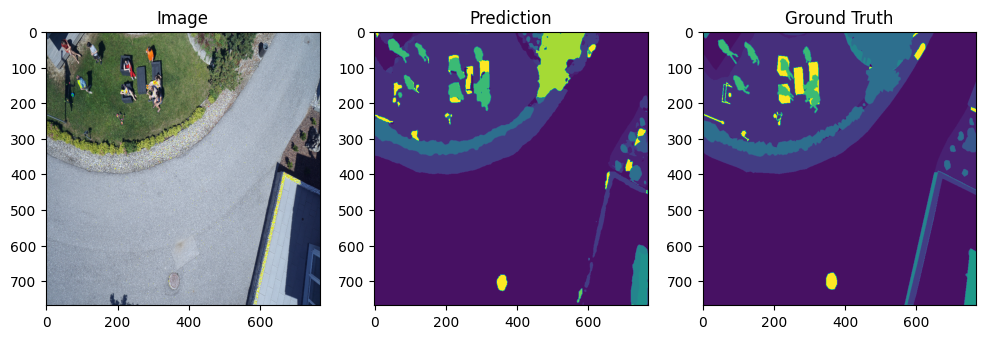

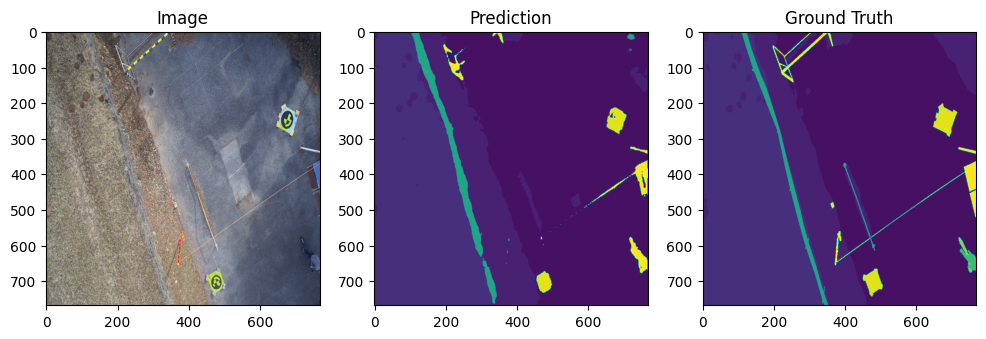

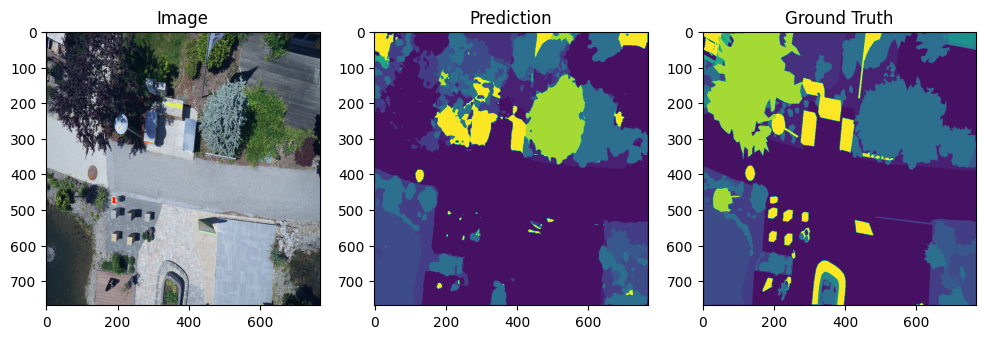

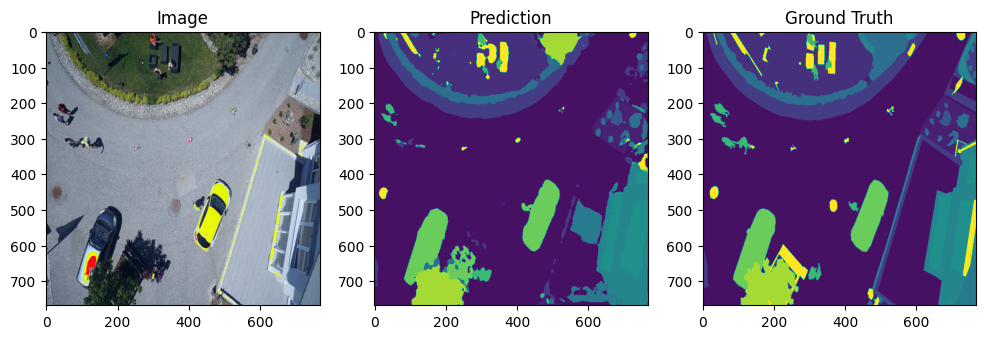

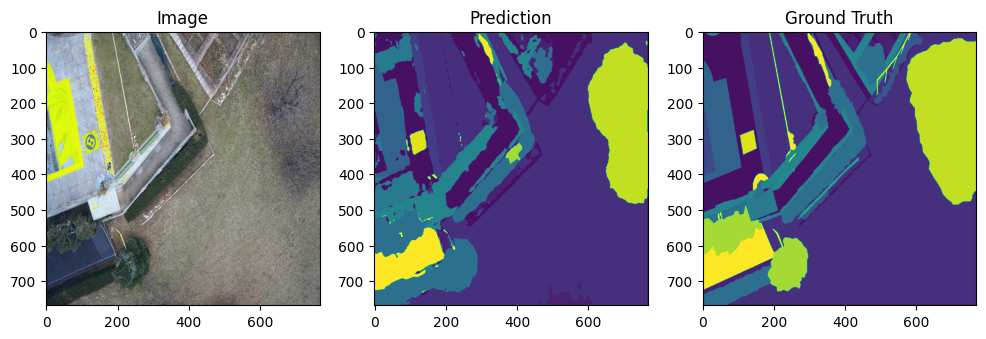

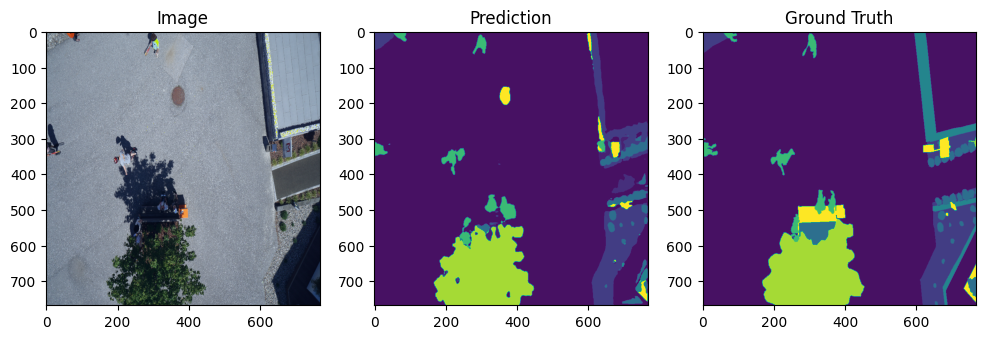

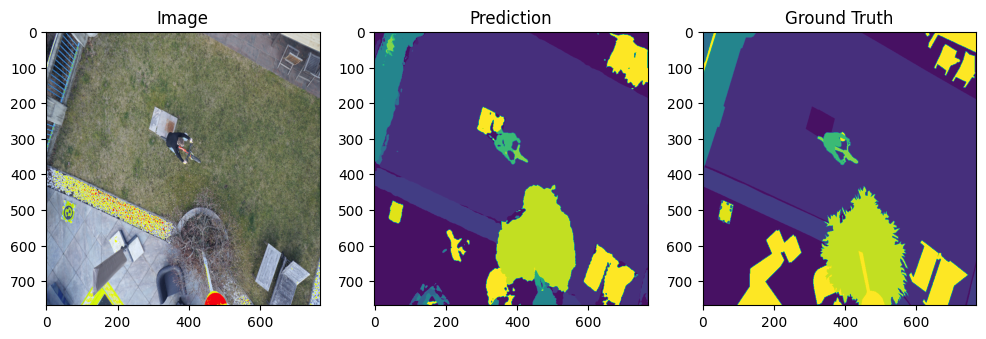

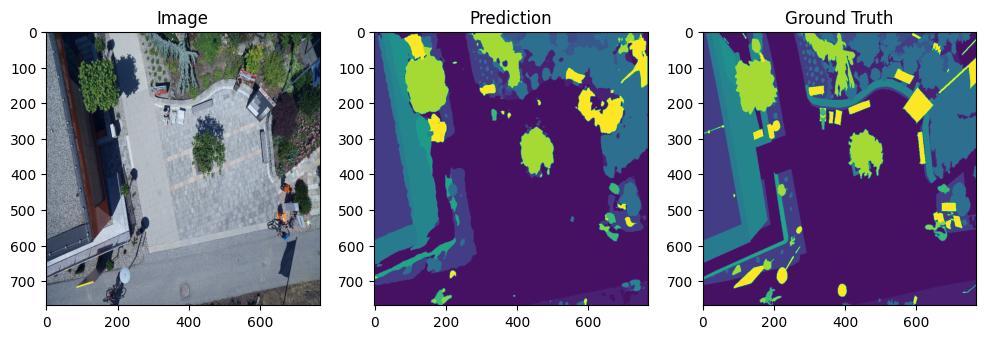

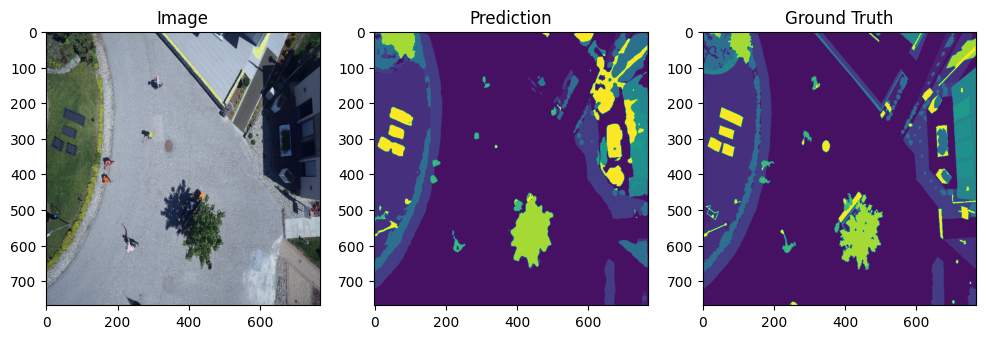

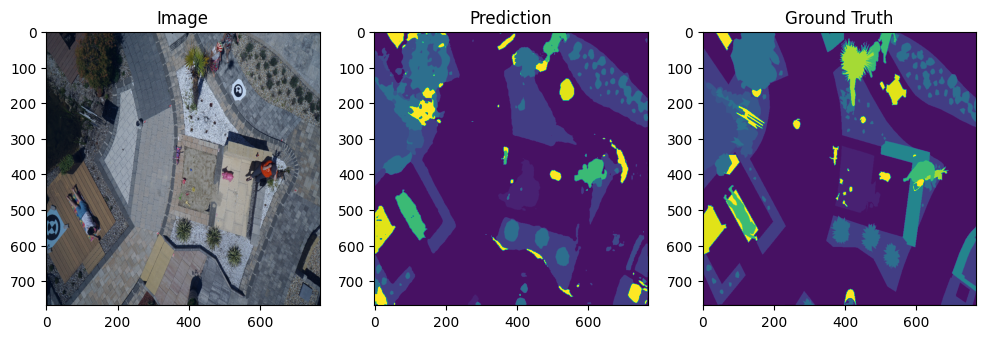

In [34]:
visualize_predictions(
    inputs,
    outputs,
    labels
)